# Data Analysis 
I will be using this notebook to analyse the data I have recorded, find correllations, and see if my assumptions about the data are correct or not. I would also like to acknowledge here that the process of recording the data was not perfect as the F125's violation system can be inconsistent at times. Another thing to mention is that the region where a driver brakes or hits the throttle are not the only factors that can cause them to crash or violate the track limits, there can be other reasons like the position of their steering, wheel, track conditions, etc. that are not in the scope of this project.

## Assumptions
My assumptions are as follows:

- I believe that the time between the moment a driver hits the brakes and hits the throttle is correllated to the overall lap time. My reasoning is that if the time difference between those inputs is too high, the car is slower for longer.
- I think that the number of times a car brakes is also correllated to the overall lap time. I think this is because the car is slowing down at another point in the lap which may be unneccessary if the driver takes a better racing line with lesser number of braking needed but this may be wrong as sometimes slowing down to take a turn and hitting the apex can be better than forcing the car to turn at a higher speed and missing the apex.
-  

## Exploring the data 
In the code chunk below I have imported all the libraries I require for the data analysis and have loaded the data as well.

In [7]:
# FIRST EDITED: 14/02/2026

import csv
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("../Data/collated-data/lap-image-association.csv")

# in the arrays below, s1 means sector 1
s1_num = df["lap_num"].to_numpy()
s1_times = df["s1_time"].to_numpy()
s1_incident = df["incident"].to_numpy()
s1_b_t_deltas = df["brake_throttle_deltas"].to_numpy()
s1_brake_hits = df["related_b_hits"].to_numpy()
s1_throttle_hits = df["related_t_hits"].to_numpy()
#print(df.head)

# LAST EDITED: 

In the code chunk below, I will some data.

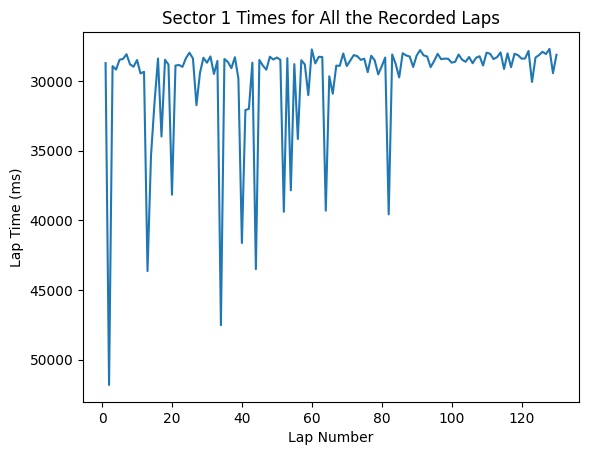

In [11]:
# FIRST EDITED: 14/02/2026

plt.plot(s1_num, s1_times)
plt.gca().invert_yaxis()
plt.title("Sector 1 Times for All the Recorded Laps")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (ms)")

plt.show()

# LAST EDITED: 14/02/2026